In [1]:
import numpy as np
import pandas as pd

In [7]:
data = np.loadtxt("data/anomaly_detection_data.csv", delimiter=",", skiprows=1)
print(data.shape)

(1000, 4)


In [8]:
print(data)

[[-1.31972372 -0.70224054  0.5381744   0.        ]
 [ 0.2089441   0.97200235  0.05748056  0.        ]
 [-0.58130205 -0.96578832  0.78529861  0.        ]
 ...
 [ 0.55021562 -0.55310618 -0.68906613  0.        ]
 [ 0.07166259 -0.32958773 -1.78144195  0.        ]
 [ 1.40175989 -0.36985075  0.11101135  0.        ]]


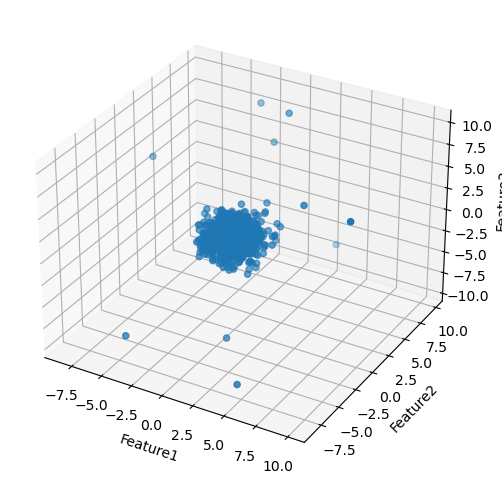

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['Feature1'], df['Feature2'], df['Feature3'])

ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')

plt.show()


In [13]:
def calculate_normalD(X): 
    u = np.mean(X, axis = 0)
    variance = np.mean((X-u)**2,axis = 0)
    return u, variance

In [25]:
from sklearn.model_selection import train_test_split

#label 
normal_data = data[data[:, -1] == 0]  
anomalies = data[data[:, -1] == 1]

# 700 normal data for training, the rest for temporary holdout
train_normal, temp_normal = train_test_split(normal_data, train_size=700, random_state=15)

#the remaining normal data and anomalies evenly into validation and test
valid_normal, test_normal = train_test_split(temp_normal, test_size=0.5, random_state=15)
valid_anomalies, test_anomalies = train_test_split(anomalies, test_size=0.5, random_state=15)

#validation and test sets by combining normal data and anomalies
valid_data = np.concatenate([valid_normal, valid_anomalies])
test_data = np.concatenate([test_normal, test_anomalies])

# shuffling
rng = np.random.default_rng(42)
rng.shuffle(valid_data)
rng.shuffle(test_data)

print(train_normal)


[[-0.07595038 -0.00656654  0.53840828  0.        ]
 [-0.25866891 -0.79116556 -0.81205287  0.        ]
 [ 0.62341089 -0.83519083  0.5622901   0.        ]
 ...
 [ 1.00121761 -1.21070407  0.26084974  0.        ]
 [-1.30630564  0.20403639  1.0824843   0.        ]
 [ 2.17535586  2.09846299 -0.34232474  0.        ]]


In [23]:
u, variance = calculate_normalD(train_normal)              

print("Mean of each feature:", u)
print("Variance of each feature:", variance)

Mean of each feature: [ 0.02753672 -0.01018481  0.01708815  0.        ]
Variance of each feature: [0.96194876 0.96095758 1.04189886 0.        ]


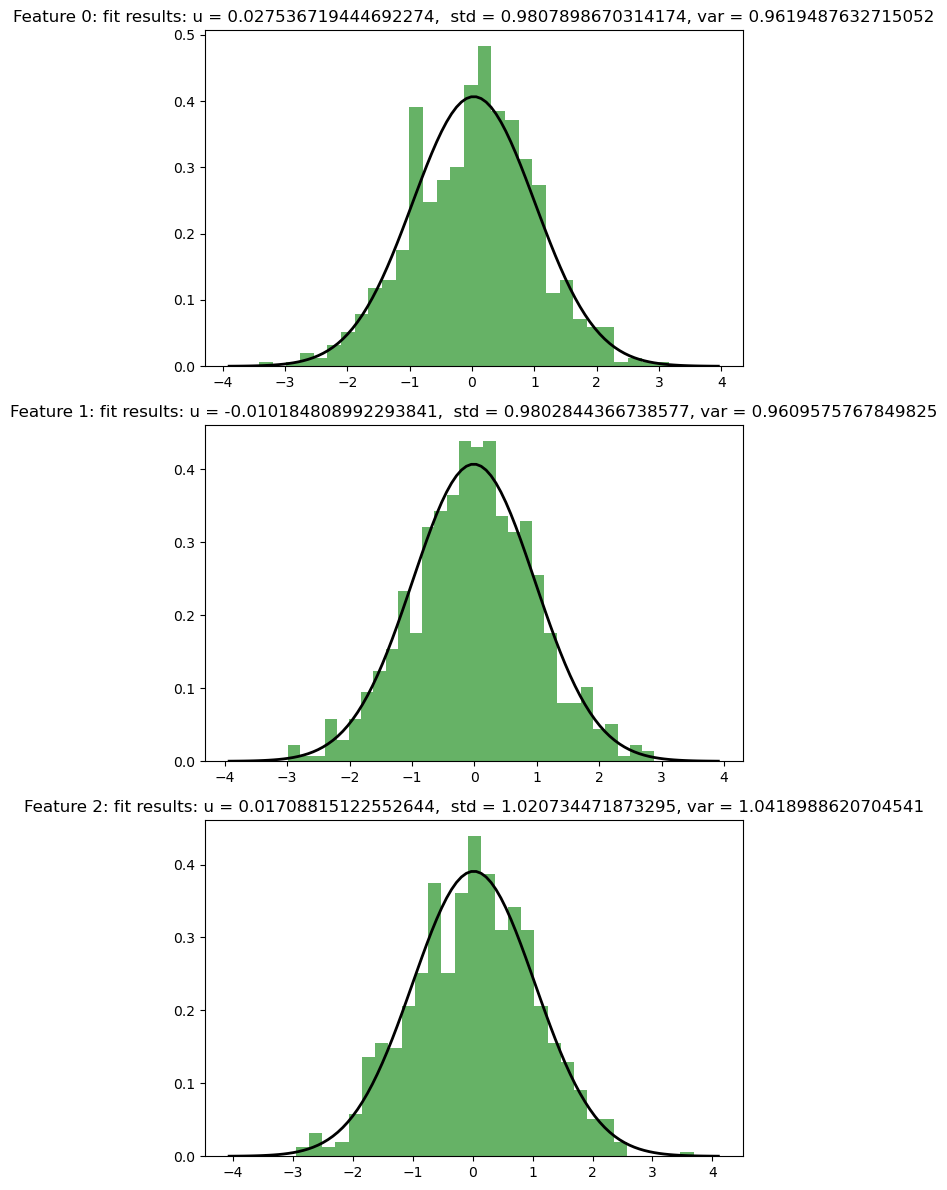

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

num_features = train_normal.shape[1] - 1

fig, axs = plt.subplots(num_features, 1, figsize=(6, 4 * num_features))

for i in range(num_features):
    # histogram of the data for the current feature
    axs[i].hist(train_normal[:, i], bins=30, density=True, alpha=0.6, color='g')

    # range of x values for the fitted distribution
    std_dev = np.sqrt(variance[i])
    xmin = u[i] - 4 * std_dev
    xmax = u[i] + 4 * std_dev
    x = np.linspace(xmin, xmax, 100)

    # fitted normal distribution using the calculated mean and variance
    p = norm.pdf(x, u[i], std_dev)

    # plotting the fitted distribution
    axs[i].plot(x, p, 'k', linewidth=2)
    title = f"Feature {i}: fit results: u = {u[i]},  std = {std_dev}, var = {variance[i]}"
    axs[i].set_title(title)

plt.tight_layout()
plt.show()


In [27]:
def calculate_probability_density(data, mean, variance):
    num_features = len(mean)
    
    if variance.ndim == 1:
        variance = np.diag(variance)
    
    data_minus_mean = data - mean

    probability_density = (1 / (2 * np.pi)**(num_features / 2) * np.linalg.det(variance)**(-0.5)) * \
        np.exp(-0.5 * np.sum((data_minus_mean @ np.linalg.pinv(variance)) * data_minus_mean, axis=1))
    
    return probability_density


In [40]:
def calculate_optimal_threshold(true_labels, probability_densities):
    best_threshold = 0
    best_f1_score = 0
    epsilon = 1e-8
    
    step_size = (np.max(probability_densities) - np.min(probability_densities)) / 1000

    for threshold in np.arange(np.min(probability_densities), np.max(probability_densities), step_size):
        predictions = probability_densities < threshold
        
        true_positives = np.sum((predictions == 1) & (true_labels == 1))
        false_positives = np.sum((predictions == 1) & (true_labels == 0))
        false_negatives = np.sum((predictions == 0) & (true_labels == 1))
        
        precision = true_positives / (true_positives + false_positives + epsilon)
        recall = true_positives / (true_positives + false_negatives + epsilon)
        
        
        if precision + recall != 0:
            f1_score = 2 * precision * recall / (precision + recall)
        else:
            f1_score = 0
            
        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_threshold = threshold

    return best_threshold, best_f1_score


In [41]:
p_d = calculate_probability_density(valid_data[:,:-1], u[:-1], variance[:-1])
epsilon, F1 = calculate_optimal_threshold(valid_data[:,-1], p_d)

print("Cross-validation")
print('Best epsilon: %e' % epsilon)
print('Best F1: %f' % F1)



Cross-validation
Best epsilon: 6.214461e-05
Best F1: 1.000000


In [43]:
p_d_test = calculate_probability_density(test_data[:,:-1], u[:-1], variance[:-1])

predictions_test = p_d_test < epsilon

accuracy = np.sum(predictions_test == test_data[:,-1]) / len(test_data)

print("Test accuracy:", accuracy)


Test accuracy: 1.0


In [46]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, f1_score

train_data = train_normal
# fitting the model
clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.fit(train_data[:,:-1]) #training on features only, not on labels

# predicting the anomalies in the validation data
preds_valid = clf.predict(valid_data[:,:-1])
print(preds_valid)
preds_valid = [1 if x == -1 else 0 for x in preds_valid]

# the validation F1 score
print('Validation F1 score:', f1_score(valid_data[:,-1], preds_valid))

# the anomalies in the test data
preds_test = clf.predict(test_data[:,:-1])
preds_test = [1 if x == -1 else 0 for x in preds_test]
#the test accuracy
print('Test accuracy:', accuracy_score(test_data[:,-1], preds_test))

#the test F1 score
print('Test F1 score:', f1_score(test_data[:,-1], preds_test))


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]
Validation F1 score: 1.0
Test accuracy: 1.0
Test F1 score: 1.0


In [47]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
clf.fit(train_data[:,:-1])

preds_valid = clf.predict(valid_data[:,:-1])
preds_valid = [1 if x == -1 else 0 for x in preds_valid]

print('Validation F1 score:', f1_score(valid_data[:,-1], preds_valid))

preds_test = clf.predict(test_data[:,:-1])
preds_test = [1 if x == -1 else 0 for x in preds_test]

print('Test accuracy:', accuracy_score(test_data[:,-1], preds_test))
print('Test F1 score:', f1_score(test_data[:,-1], preds_test))


Validation F1 score: 0.8333333333333333
Test accuracy: 1.0
Test F1 score: 1.0


In [54]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(contamination=outliers_fraction)
clf.fit(train_data[:,:-1])

preds_valid = clf.predict(valid_data[:,:-1])
preds_valid = [1 if x == -1 else 0 for x in preds_valid]

print('Validation F1 score:', f1_score(valid_data[:,-1], preds_valid))

preds_test = clf.predict(test_data[:,:-1])
preds_test = [1 if x == -1 else 0 for x in preds_test]

print('Test accuracy:', accuracy_score(test_data[:,-1], preds_test))
print('Test F1 score:', f1_score(test_data[:,-1], preds_test))


Validation F1 score: 1.0
Test accuracy: 1.0
Test F1 score: 1.0
